In [1]:
import pandas as pd
import numpy as np
from collections import Counter

from cycler import cycler

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation, FFMpegWriter

from datetime import datetime
from datetime import timedelta

import matplotlib.animation as animation
import shutil

import matplotlib.dates as mdates

import collections

from IPython.display import clear_output
import calplot
import july
import calmap

In [2]:
### Set up fonts
from matplotlib.font_manager import fontManager, FontProperties

path = "/Users/gabrielbenitez/Library/Fonts/Sora-VariableFont_wght.ttf"

fontManager.addfont(path)
prop = FontProperties(fname=path)

plt.rcParams['font.sans-serif'] = prop.get_name()

In [44]:
### Set up color palettes
sns.color_palette("blend:#184918,#F1EAE4", as_cmap = True)
sns.blend_palette(['#000000', '#184918', '#184918',  '#F1EAE4',], as_cmap = True)

black_col = '#000000'
bg_col = '#F4F1E7'

col_list = ['#ED7D3A', 
            '#314CB6', 
            '#2FBF71', 
            '#D991BA',
            '#EFCA08', 
            '#64113F',
            bg_col, 
            black_col, 
           '#773344', 
            '#606C38'
           ] 
            
            

pal = sns.color_palette(col_list)
pal

[(0.9294117647058824, 0.49019607843137253, 0.22745098039215686),
 (0.19215686274509805, 0.2980392156862745, 0.7137254901960784),
 (0.1843137254901961, 0.7490196078431373, 0.44313725490196076),
 (0.8509803921568627, 0.5686274509803921, 0.7294117647058823),
 (0.9372549019607843, 0.792156862745098, 0.03137254901960784),
 (0.39215686274509803, 0.06666666666666667, 0.24705882352941178),
 (0.9568627450980393, 0.9450980392156862, 0.9058823529411765),
 (0.0, 0.0, 0.0),
 (0.4666666666666667, 0.2, 0.26666666666666666),
 (0.3764705882352941, 0.4235294117647059, 0.2196078431372549)]

In [70]:
plt.rcParams['figure.facecolor']  = bg_col
plt.rcParams['figure.edgecolor']  = bg_col
plt.rcParams['axes.facecolor'] =  bg_col

#colour of text and ticks
mpl.rcParams['text.color'] = black_col
mpl.rcParams['axes.labelcolor'] = black_col
mpl.rcParams['axes.edgecolor'] = black_col
mpl.rcParams['xtick.color'] = black_col
mpl.rcParams['ytick.color'] = black_col

#top and right spines
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

#x ticks
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.rcParams["font.family"] = prop.get_name()

In [71]:
df = pd.read_csv('travel.csv')
df = df[df['Type'] == 'Train'].reset_index(drop = True)

# subset to edi-ldn trips or ldn-edi
df = df[ ( (df['From'] == 'Edinburgh') & (df['To'] == 'London') ) | ( (df['From'] == 'London') & (df['To'] == 'Edinburgh') ) ].reset_index(drop = True)

df['Day'] = df['Day'].astype(int)
df['Year'] = df['Year'].astype(int)
df['Date'] = pd.to_datetime(df[['Day', 'Month', 'Year']].astype(str).agg('-'.join, axis=1))
df['DotW'] = df['Date'].dt.day_name()

df['Path'] = df['From'] + ' - ' + df['To']

lol_d = {'Gab' : {'London - Edinburgh' : 'Departure', 
                  'Edinburgh - London' : 'Arrival' }, 
        'Emma': {'London - Edinburgh' : 'Arrival', 
                  'Edinburgh - London' : 'Departure' }
        }

df['A/R'] = df.apply(lambda x: lol_d[ x['Person']][x['Path']], axis = 1)

df = df.fillna(0)

print(len(df))
Counter(df['Person'])
df.head(10)

100


,From,To,Type,Total Distance,Travel Time,Delay,Month,Day,Company,Year,Person,Date,DotW,Path,A/R
0,London,Edinburgh,Train,531.0,4.5,0.0,October,1,LNER,2021,Gab,2021-10-01,Friday,London - Edinburgh,Departure
1,Edinburgh,London,Train,531.0,4.5,0.0,October,3,LNER,2021,Gab,2021-10-03,Sunday,Edinburgh - London,Arrival
2,London,Edinburgh,Train,531.0,4.5,0.0,December,4,LNER,2021,Gab,2021-12-04,Saturday,London - Edinburgh,Departure
3,Edinburgh,London,Train,531.0,4.5,0.0,December,12,LNER,2021,Gab,2021-12-12,Sunday,Edinburgh - London,Arrival
4,London,Edinburgh,Train,531.0,4.5,0.0,January,21,LNER,2022,Gab,2022-01-21,Friday,London - Edinburgh,Departure
5,Edinburgh,London,Train,531.0,4.5,0.0,January,25,LNER,2022,Gab,2022-01-25,Tuesday,Edinburgh - London,Arrival
6,London,Edinburgh,Train,531.0,4.5,0.0,February,26,LNER,2022,Gab,2022-02-26,Saturday,London - Edinburgh,Departure
7,London,Edinburgh,Train,531.0,4.5,0.0,April,14,Lumo,2022,Gab,2022-04-14,Thursday,London - Edinburgh,Departure
8,Edinburgh,London,Train,531.0,4.5,0.0,April,19,Lumo,2022,Gab,2022-04-19,Tuesday,Edinburgh - London,Arrival
9,London,Edinburgh,Train,531.0,4.5,0.0,July,4,LNER,2022,Gab,2022-07-04,Monday,London - Edinburgh,Departure


In [72]:
# We reformat our dataframe, such that
# Person | Date | Total Trains Taken

temp = []
full_date_range = pd.DataFrame({'Date': pd.date_range(start=df['Date'].min(), 
                                                      end='2024-09-17', 
                                                      freq='D')})

for i in ['Gab', 'Emma']:
    t = df[['Person', 'Date']][df['Person'] == i].sort_values(by = 'Date').reset_index(drop = True)
    td = dict(zip(t['Date'], np.arange(1, len(t)+1)))

    date_fill = full_date_range.merge(t, on = 'Date', how = 'left')
    date_fill['TrainsTaken'] = date_fill['Date'].map(td).ffill().fillna(0)
    date_fill['Person'] = i
    temp.append(date_fill)

temp = pd.concat(temp).reset_index(drop = True)
temp

,Date,Person,TrainsTaken
0,2021-09-17,Gab,0.0
1,2021-09-18,Gab,0.0
2,2021-09-19,Gab,0.0
3,2021-09-20,Gab,0.0
4,2021-09-21,Gab,0.0
...,...,...,...
2189,2024-09-13,Emma,56.0
2190,2024-09-14,Emma,56.0
2191,2024-09-15,Emma,56.0
2192,2024-09-16,Emma,56.0


In [73]:
# def live_plot(data_dict, title_str, dates, figsize=(6,4)):
#     clear_output(wait=True)
#     plt.figure(figsize=figsize, dpi=200)

#     # Convert list of dates to pandas datetime for proper formatting
#     dates = pd.to_datetime(dates)

#     for label, data in data_dict.items():
#         plt.plot(dates[:len(data)], data, label=label)  # Ensure x-axis is aligned
    
#     plt.grid(False)
#     plt.legend(loc=(0, 1.04))

#     # Set major ticks for every month, but only label January, April, July, October
#     ax = plt.gca()
#     ax.xaxis.set_major_locator(mdates.MonthLocator())  # Ticks for every month
#     ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # Labels only for Jan, Apr, Jul, Oct
#     ax.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
    
#     for label in ax.get_xticklabels():
#         if label.get_text().split(',')[0] not in ["January", "April", "July", "October"]:
#             label.set_visible(False)  # Hide labels for other months
    
#     plt.xticks(rotation=45)
    
#     # Add vertical red lines for each January 1st with annotations
#     for year in range(dates.min().year, dates.max().year + 1):
#         jan_first = pd.Timestamp(year=year, month=1, day=1)
#         if jan_first in dates.values:
#             plt.axvline(jan_first, color='grey', linestyle='--', alpha=0.7)
#             plt.text(jan_first, plt.ylim()[1]+3, str(year), color='grey', fontsize=8, ha='left')

#     plt.ylim(0, plt.ylim()[1]+3)
#     plt.ylabel('Trains Taken')
#     plt.xlabel('Date')
    
#     # Annotate the last data point with its y-value
#     last_date = dates[-1]
#     # for Emma
#     plt.plot(last_date, int(data_dict['Emma'][-1]), 'o', color = sns.color_palette()[0])
#     plt.annotate(f'{int(data_dict['Emma'][-1])}', xy=(last_date, int(data_dict['Emma'][-1])), 
#                  xytext=(last_date, int(data_dict['Emma'][-1]) + 0.5),
#                  fontsize=8)

#     # for Gab
#     plt.plot(last_date, int(data_dict['Gab'][-1]), 'o', color = sns.color_palette()[1])
#     plt.annotate(f'{int(data_dict['Gab'][-1])}', xy=(last_date, int(data_dict['Gab'][-1])), 
#                  xytext=(last_date, int(data_dict['Gab'][-1]) + 0.5), 
#                  fontsize=8)

#     plt.suptitle(title_str, y = 1.03)
#     plt.title('Trains Taken Between EDI and LDN Across 3 Years', fontsize = 7, y = 1.05)
#     plt.show()

In [74]:
# data = collections.defaultdict(list)
# dates = []  # Store unique dates for x-axis

# for day, i in enumerate(temp['Date'].unique()):
#     dates.append(i)  # Store date
#     data['Emma'].append(temp[(temp['Date'] == i) & (temp['Person'] == 'Emma')]['TrainsTaken'].values[0])
#     data['Gab'].append(temp[(temp['Date'] == i) & (temp['Person'] == 'Gab')]['TrainsTaken'].values[0])

#     live_plot(data, f'Trains Taken - Day: {day}', dates)

In [75]:
def update(frame):
    ax.clear()
    
    # Plot only up to the current frame
    current_dates = dates[:frame + 1]
    ax.plot(current_dates, data['Emma'][:frame + 1], label='Emma', color='#773344')
    ax.plot(current_dates, data['Gab'][:frame + 1], label='Gab', color='#606C38')

    # Ensure all text is inside the plot

    # Set legend at the top right (inside plot, not overlapping)
    ax.legend(loc=(1, 1.05), bbox_to_anchor=(0.9, 1), fontsize=8, frameon=False)

    # Set x-axis major ticks and labels
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%B"))

    # Show only labels for January, April, July, October
    for label in ax.get_xticklabels():
        if label.get_text().split(',')[0] not in ["January", "April", "July", "October"]:
            label.set_visible(False)

    ax.set_ylim(0, max(max(data['Emma']), max(data['Gab'])) + 5)  # More space for text
    plt.xticks(rotation=45, size=8)

    ax.text(dates[0], ax.get_ylim()[1] - 2, '2021', color='grey', fontsize=8, ha='left')

    # Add vertical lines only after the data passes the year mark
    for year in range(dates.min().year, dates.max().year + 1):
        jan_first = pd.Timestamp(year=year, month=1, day=1)

        if jan_first in current_dates:
            ax.axvline(jan_first, color='grey', linestyle='--', alpha=0.7)
            ax.text(jan_first, ax.get_ylim()[1] - 2, str(year), color='grey', fontsize=8, ha='left')

    # Annotate last data point
    if frame > 0:
        last_date = current_dates[-1]
        
        ax.plot(last_date, data['Emma'][frame], 'o', color='#773344')
        ax.annotate(f'{int(data["Emma"][frame])}', xy=(last_date, data["Emma"][frame]), 
                    xytext=(last_date, data["Emma"][frame] + 0.5), fontsize=8)

        ax.plot(last_date, data['Gab'][frame], 'o', color='#606C38')
        ax.annotate(f'{int(data["Gab"][frame])}', xy=(last_date, data["Gab"][frame]), 
                    xytext=(last_date, data["Gab"][frame] + 0.5), fontsize=8)


    # titles and formatting
    fig.suptitle(f" Trains Taken: { int(data['Emma'][frame]) + int(data['Gab'][frame]) } --- Day: {frame}", fontsize=12, y = 0.96)
    ax.set_title(f"Cumulative Trains Taken Between EDI and LDN Across 3 Years", fontsize=8, pad=8)
    ax.set_ylabel("Trains Taken", fontsize=8)
    plt.tight_layout()

In [76]:
data = collections.defaultdict(list)
dates = []  # Store unique dates for x-axis

for i in temp['Date'].unique():
    dates.append(i)  # Store date
    data['Emma'].append(temp[(temp['Date'] == i) & (temp['Person'] == 'Emma')]['TrainsTaken'].values[0])
    data['Gab'].append(temp[(temp['Date'] == i) & (temp['Person'] == 'Gab')]['TrainsTaken'].values[0])

# Convert dates to pandas datetime
dates = pd.to_datetime(dates)

Video saved as train_data_animation.mp4
CPU times: user 4min 38s, sys: 2.93 s, total: 4min 41s
Wall time: 1min 34s


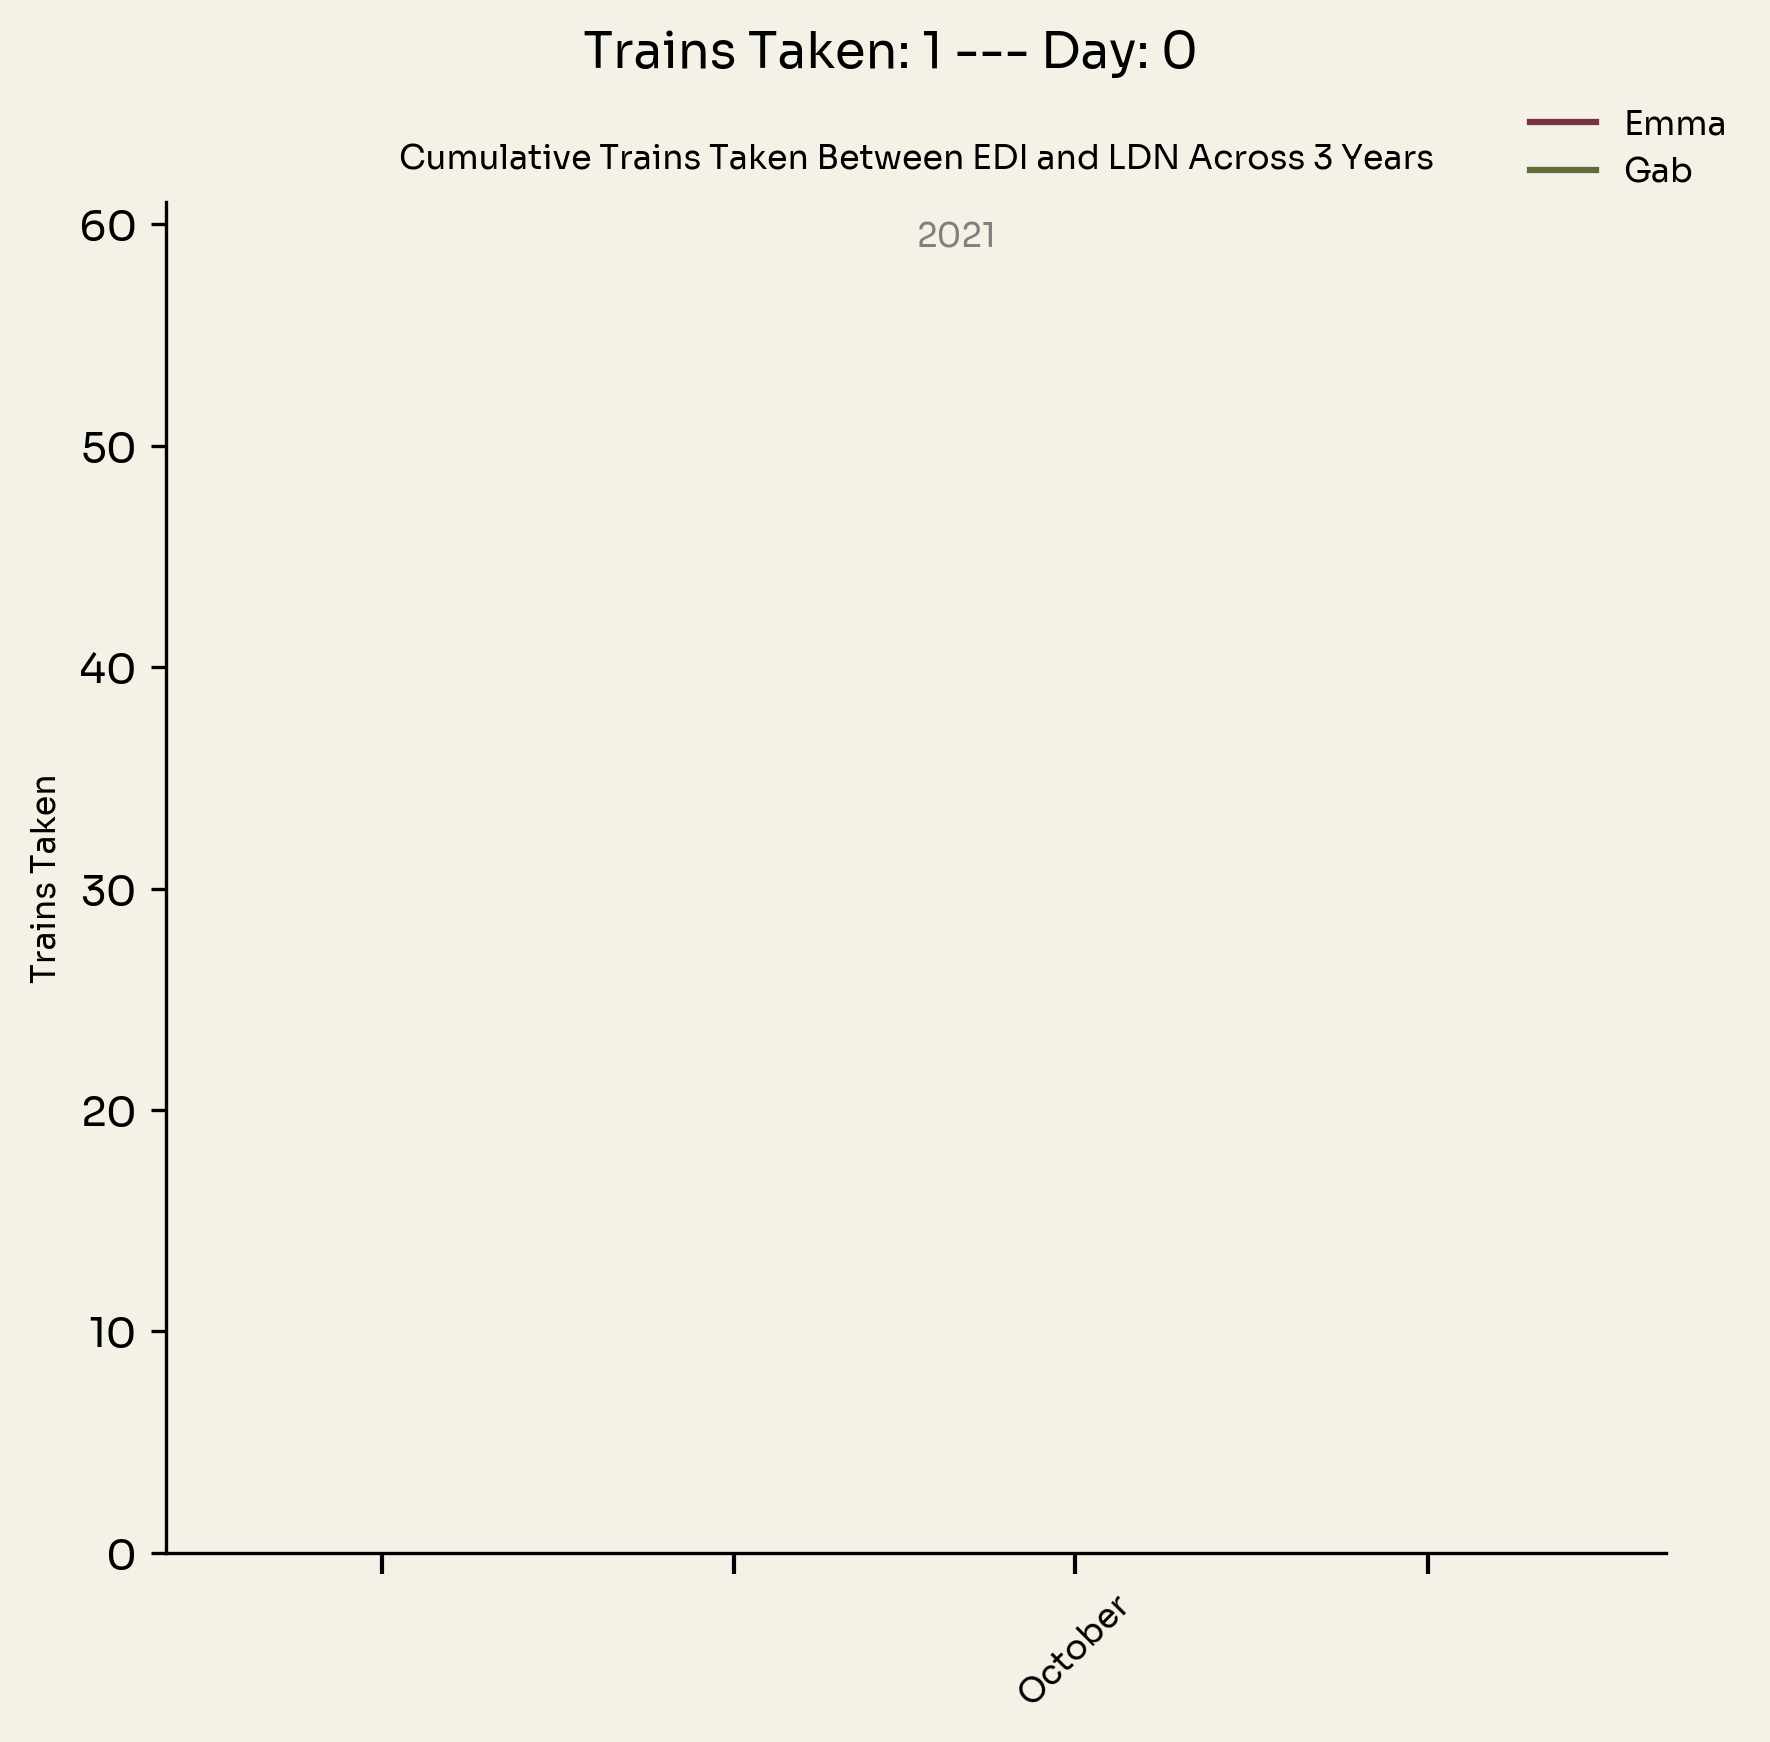

In [77]:
%%time

fig, ax = plt.subplots(figsize=(6, 6), dpi=300) 

plt.tight_layout(rect=[0, 0.03, 1, 0.92])

# Create animation
num_frames = len(dates)
ani = animation.FuncAnimation(fig, update, frames=num_frames, repeat=False)

video_filename = "train_data_animation.mp4"
fps = 30

writer = animation.FFMpegWriter(fps=fps)
ani.save(video_filename, writer=writer)

print(f"Video saved as {video_filename}")

In [15]:
# df = pd.read_csv('travel.csv')
# df = df[df['Type'] == 'Train'].reset_index(drop = True)

# # subset to edi-ldn trips or ldn-edi
# df = df[ ( (df['From'] == 'Edinburgh') & (df['To'] == 'London') ) | ( (df['From'] == 'London') & (df['To'] == 'Edinburgh') ) ].reset_index(drop = True)

# df['Day'] = df['Day'].astype(int)
# df['Year'] = df['Year'].astype(int)
# df['Date'] = pd.to_datetime(df[['Day', 'Month', 'Year']].astype(str).agg('-'.join, axis=1))
# df['DotW'] = df['Date'].dt.day_name()

# df['Path'] = df['From'] + ' - ' + df['To']

# lol_d = {'Gab' : {'London - Edinburgh' : 'Departure', 
#                   'Edinburgh - London' : 'Arrival' }, 
#         'Emma': {'London - Edinburgh' : 'Arrival', 
#                   'Edinburgh - London' : 'Departure' }
#         }

# df['A/R'] = df.apply(lambda x: lol_d[ x['Person']][x['Path']], axis = 1)

# df = df.fillna(0)

# # Remove one way trips for Gab
# df = df.drop(6)
# df = df.drop(43)

# # remove one way/work trips for Emma
# df=df.drop(52)

# df=df.drop(63)
# df=df.drop(64)

# df=df.drop(73)

# df=df.drop(80)

# df=df.drop(89)
# df=df.drop(90)

# df=df.drop(95)
# df=df.drop(96)
# df=df.drop(99)

# df.head(3)

In [37]:
df = pd.read_csv('travel.csv')
df = df[df['Type'] == 'Train'].reset_index(drop = True)

# subset to edi-ldn trips or ldn-edi
df = df[ ( (df['From'] == 'Edinburgh') & (df['To'] == 'London') ) | ( (df['From'] == 'London') & (df['To'] == 'Edinburgh') ) ].reset_index(drop = True)

df['Day'] = df['Day'].astype(int)
df['Year'] = df['Year'].astype(int)
df['Date'] = pd.to_datetime(df[['Day', 'Month', 'Year']].astype(str).agg('-'.join, axis=1))
df['DotW'] = df['Date'].dt.day_name()

df['Path'] = df['From'] + ' - ' + df['To']
df

,From,To,Type,Total Distance,Travel Time,Delay,Month,Day,Company,Year,Person,Date,DotW,Path
0,London,Edinburgh,Train,531.0,4.5,NaN,October,1,LNER,2021,Gab,2021-10-01,Friday,London - Edinburgh
1,Edinburgh,London,Train,531.0,4.5,NaN,October,3,LNER,2021,Gab,2021-10-03,Sunday,Edinburgh - London
2,London,Edinburgh,Train,531.0,4.5,NaN,December,4,LNER,2021,Gab,2021-12-04,Saturday,London - Edinburgh
3,Edinburgh,London,Train,531.0,4.5,NaN,December,12,LNER,2021,Gab,2021-12-12,Sunday,Edinburgh - London
4,London,Edinburgh,Train,531.0,4.5,NaN,January,21,LNER,2022,Gab,2022-01-21,Friday,London - Edinburgh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Edinburgh,London,Train,531.0,4.5,NaN,April,27,NaN,2024,Emma,2024-04-27,Saturday,Edinburgh - London
96,Edinburgh,London,Train,531.0,4.5,NaN,June,14,NaN,2024,Emma,2024-06-14,Friday,Edinburgh - London
97,Edinburgh,London,Train,531.0,4.5,NaN,July,19,NaN,2024,Emma,2024-07-19,Friday,Edinburgh - London
98,London,Edinburgh,Train,531.0,4.5,NaN,July,21,NaN,2024,Emma,2024-07-21,Sunday,London - Edinburgh


In [38]:
journeys = []

for i in ['Emma', 'Gab']:
    temp = df[df['Person'] == i].reset_index(drop = True)

    js = pd.DataFrame({
        "Departure": temp.loc[::2, "Date"].values,
        "Return": temp.loc[1::2, "Date"].values
    })
    js['Person'] = i
    journeys.append(js)

journeys = pd.concat(journeys).reset_index(drop = True)
journeys['Length'] = journeys['Return'] - journeys['Departure']
journeys['Departure_DotW'] = journeys['Departure'].dt.day_name()
journeys['Return_DotW'] = journeys['Return'].dt.day_name()
journeys.sample(5)

,Departure,Return,Person,Length,Departure_DotW,Return_DotW
42,2023-11-26,2023-12-07,Gab,11 days,Sunday,Thursday
4,2022-01-02,2022-03-25,Emma,82 days,Sunday,Friday
33,2022-07-10,2022-10-21,Gab,103 days,Sunday,Friday
15,2023-01-26,2023-01-30,Emma,4 days,Thursday,Monday
32,2022-04-19,2022-07-04,Gab,76 days,Tuesday,Monday


In [39]:
df = pd.read_csv('travel.csv')
df = df[df['Type'] == 'Train'].reset_index(drop = True)

# subset to edi-ldn trips or ldn-edi
df = df[ ( (df['From'] == 'Edinburgh') & (df['To'] == 'London') ) | ( (df['From'] == 'London') & (df['To'] == 'Edinburgh') ) ].reset_index(drop = True)

df['Day'] = df['Day'].astype(int)
df['Year'] = df['Year'].astype(int)
df['Date'] = pd.to_datetime(df[['Day', 'Month', 'Year']].astype(str).agg('-'.join, axis=1))
df['DotW'] = df['Date'].dt.day_name()

df['Path'] = df['From'] + ' - ' + df['To']

lol_d = {'Gab' : {'London - Edinburgh' : 'Departure', 
                  'Edinburgh - London' : 'Return' }, 
        'Emma': {'London - Edinburgh' : 'Return', 
                  'Edinburgh - London' : 'Departure' }
        }

df['A/R'] = df.apply(lambda x: lol_d[ x['Person']][x['Path']], axis = 1)

df = df.fillna(0)
df.head(3)

,From,To,Type,Total Distance,Travel Time,Delay,Month,Day,Company,Year,Person,Date,DotW,Path,A/R
0,London,Edinburgh,Train,531.0,4.5,0.0,October,1,LNER,2021,Gab,2021-10-01,Friday,London - Edinburgh,Departure
1,Edinburgh,London,Train,531.0,4.5,0.0,October,3,LNER,2021,Gab,2021-10-03,Sunday,Edinburgh - London,Return
2,London,Edinburgh,Train,531.0,4.5,0.0,December,4,LNER,2021,Gab,2021-12-04,Saturday,London - Edinburgh,Departure


In [78]:
# LMAO
temp = df.copy()
temp['Day'] = temp['DotW'].apply(lambda x: x[:3])

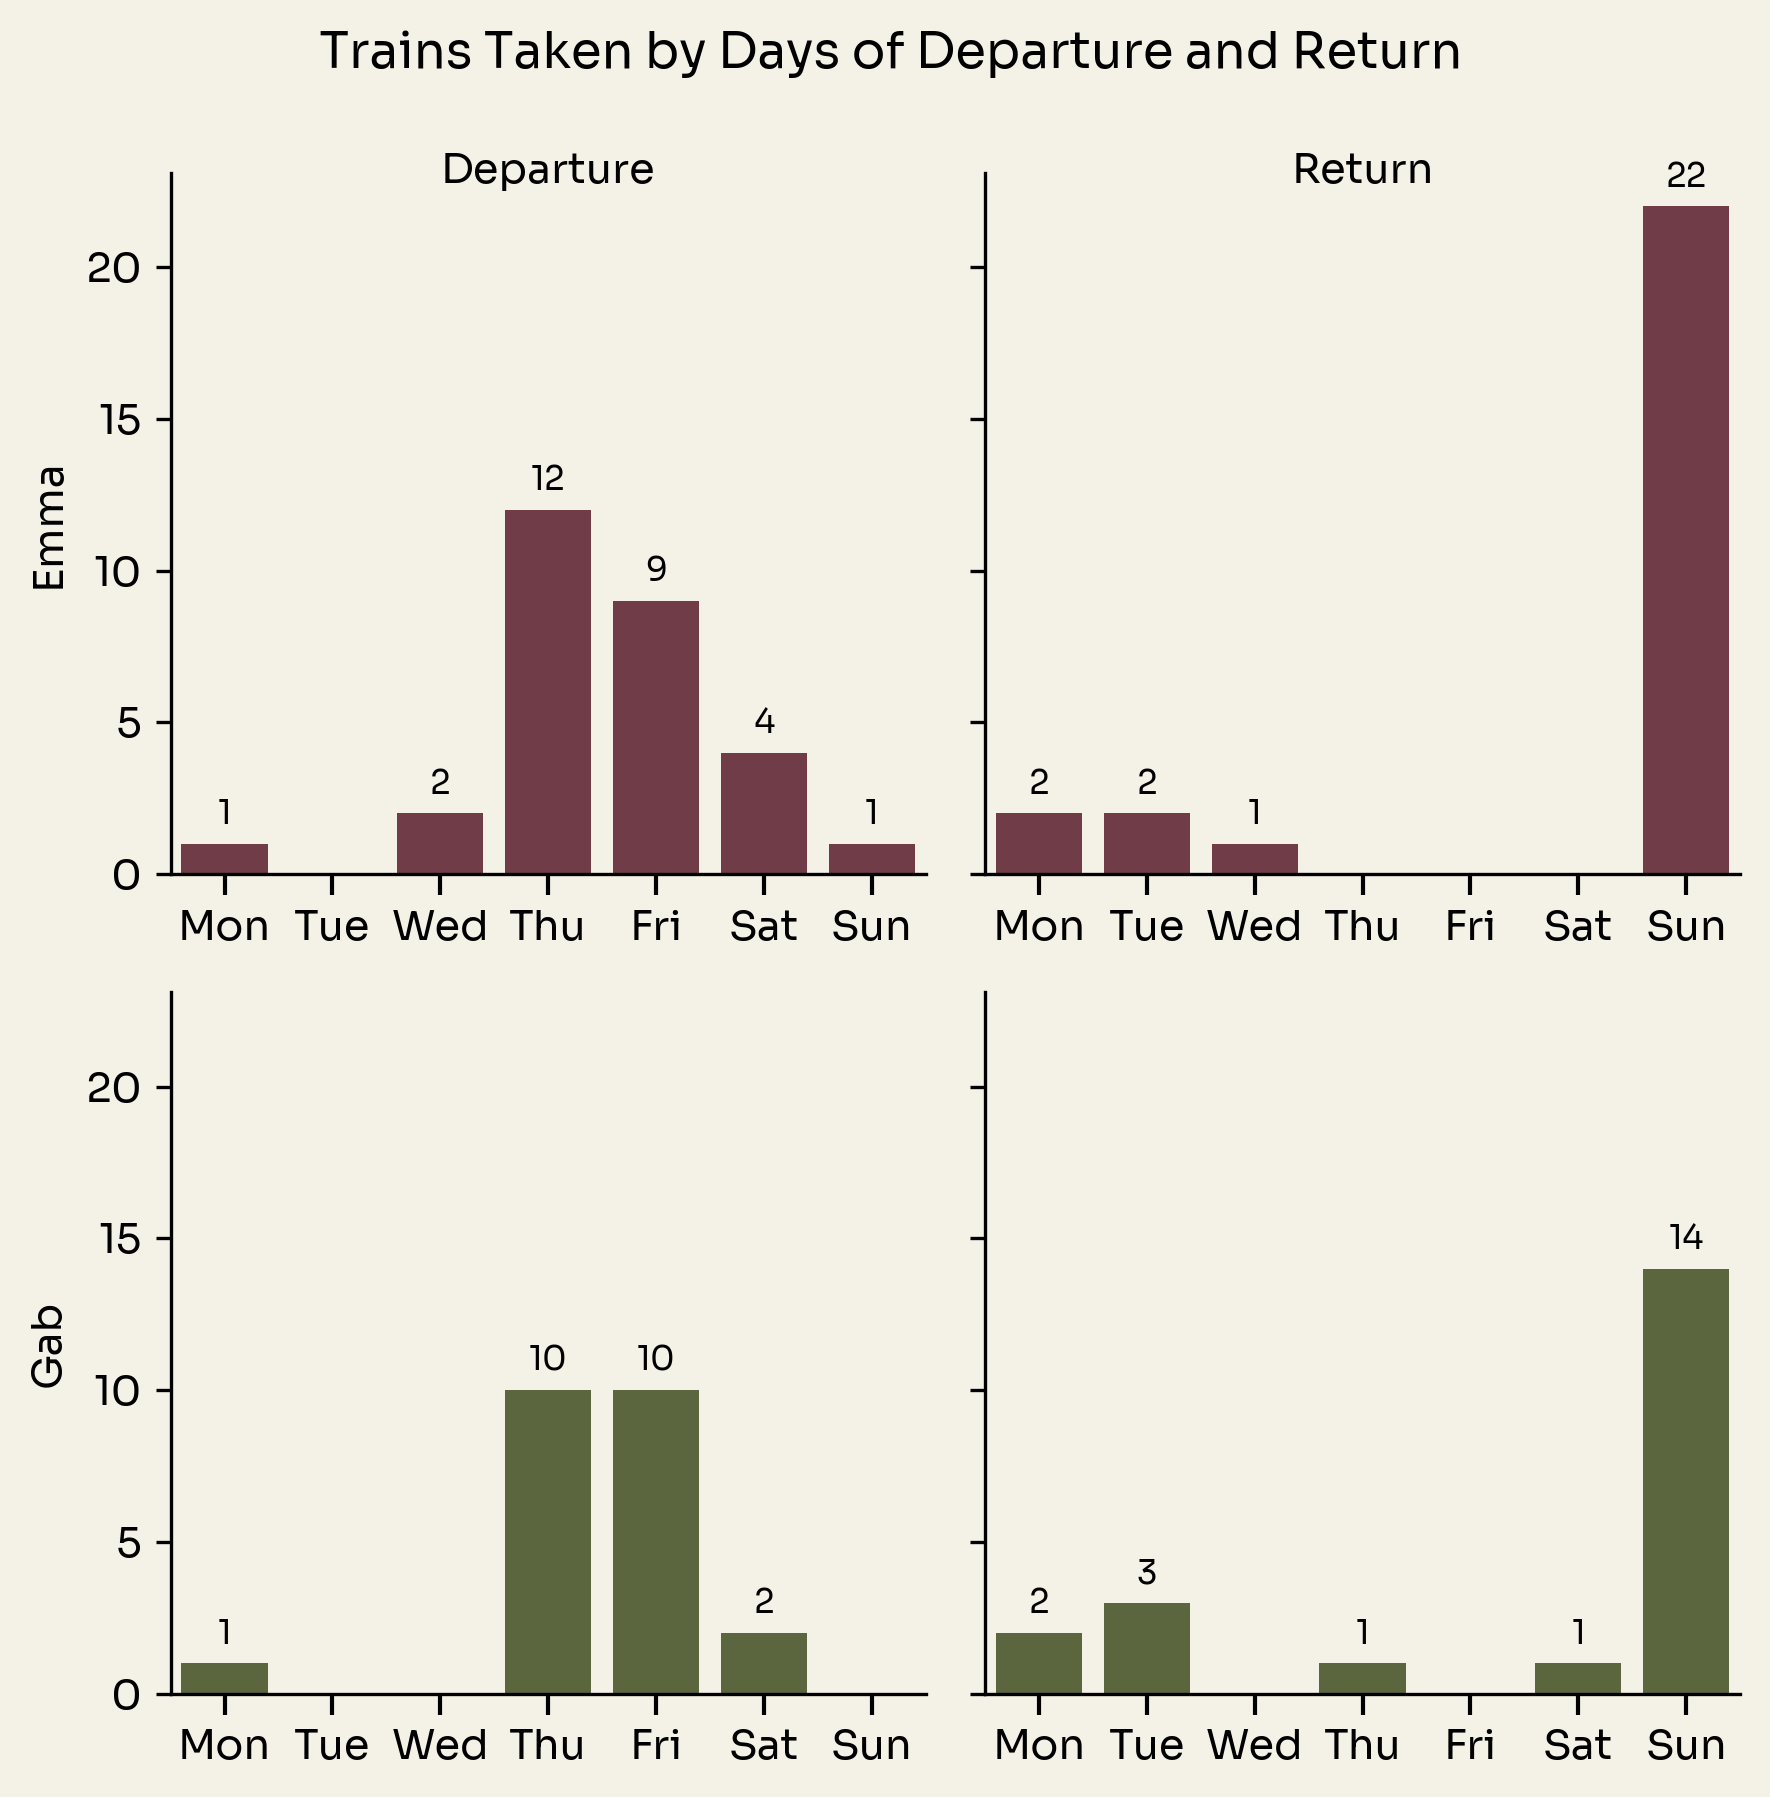

In [67]:
# 4x4 heatmap of leaving and returning to edinburgh

order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=300, sharey=True)

# Plot only in one of the subplots (e.g., top-left: ax[0, 0])

for row_idx, person in enumerate(['Emma', 'Gab']):
    for col_idx, trip in enumerate(['Departure', 'Return']):
        t = temp[(temp['Person'] == person) & (temp['A/R'] == trip)]

        if person == 'Emma':
            pal = '#773344'
        else:
            pal = '#606C38'
        
        
        sns.countplot(data=t, 
                      x='Day', 
                      order=order, 
                      color = pal,
                      ax=ax[row_idx][col_idx], 
                     )  

        ax[row_idx][col_idx].set_xlabel('', fontsize = 10)


        for container in ax[row_idx][col_idx].containers:
            ax[row_idx][col_idx].bar_label(container, fmt='%.0f', fontsize=8, padding=3)


# Formatting
ax[0][0].set_title('Departure', fontsize = 10, y = 0.95)
ax[0][1].set_title('Return', fontsize = 10, y = 0.95)
ax[0][0].set_ylabel('Emma', fontsize = 10)
ax[1][0].set_ylabel('Gab', fontsize = 10)



fig.suptitle(f" Trains Taken by Days of Departure and Return", fontsize=12, y = 0.99)

plt.tight_layout()
plt.savefig('departure_and_returns.png', dpi = 300)
plt.show()

In [79]:
df['

,From,To,Type,Total Distance,Travel Time,Delay,Month,Day,Company,Year,Person,Date,DotW,Path,A/R
0,London,Edinburgh,Train,531.0,4.5,0.0,October,1,LNER,2021,Gab,2021-10-01,Friday,London - Edinburgh,Departure
1,Edinburgh,London,Train,531.0,4.5,0.0,October,3,LNER,2021,Gab,2021-10-03,Sunday,Edinburgh - London,Arrival
2,London,Edinburgh,Train,531.0,4.5,0.0,December,4,LNER,2021,Gab,2021-12-04,Saturday,London - Edinburgh,Departure
3,Edinburgh,London,Train,531.0,4.5,0.0,December,12,LNER,2021,Gab,2021-12-12,Sunday,Edinburgh - London,Arrival
4,London,Edinburgh,Train,531.0,4.5,0.0,January,21,LNER,2022,Gab,2022-01-21,Friday,London - Edinburgh,Departure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Edinburgh,London,Train,531.0,4.5,0.0,April,27,0,2024,Emma,2024-04-27,Saturday,Edinburgh - London,Departure
96,Edinburgh,London,Train,531.0,4.5,0.0,June,14,0,2024,Emma,2024-06-14,Friday,Edinburgh - London,Departure
97,Edinburgh,London,Train,531.0,4.5,0.0,July,19,0,2024,Emma,2024-07-19,Friday,Edinburgh - London,Departure
98,London,Edinburgh,Train,531.0,4.5,0.0,July,21,0,2024,Emma,2024-07-21,Sunday,London - Edinburgh,Arrival


In [80]:
df['MapColor'] = df['Person'].apply(lambda x: 1 if x == 'Emma' else -1)
events = pd.Series(list(df['MapColor']), index = df['Date'])
events

Date
2021-10-01   -1
2021-10-03   -1
2021-12-04   -1
2021-12-12   -1
2022-01-21   -1
             ..
2024-04-27    1
2024-06-14    1
2024-07-19    1
2024-07-21    1
2024-08-05    1
Length: 100, dtype: int64

(<Figure size 1250x680 with 5 Axes>,
 array([<Axes: ylabel='2021'>, <Axes: ylabel='2022'>,
        <Axes: ylabel='2023'>, <Axes: ylabel='2024'>], dtype=object))

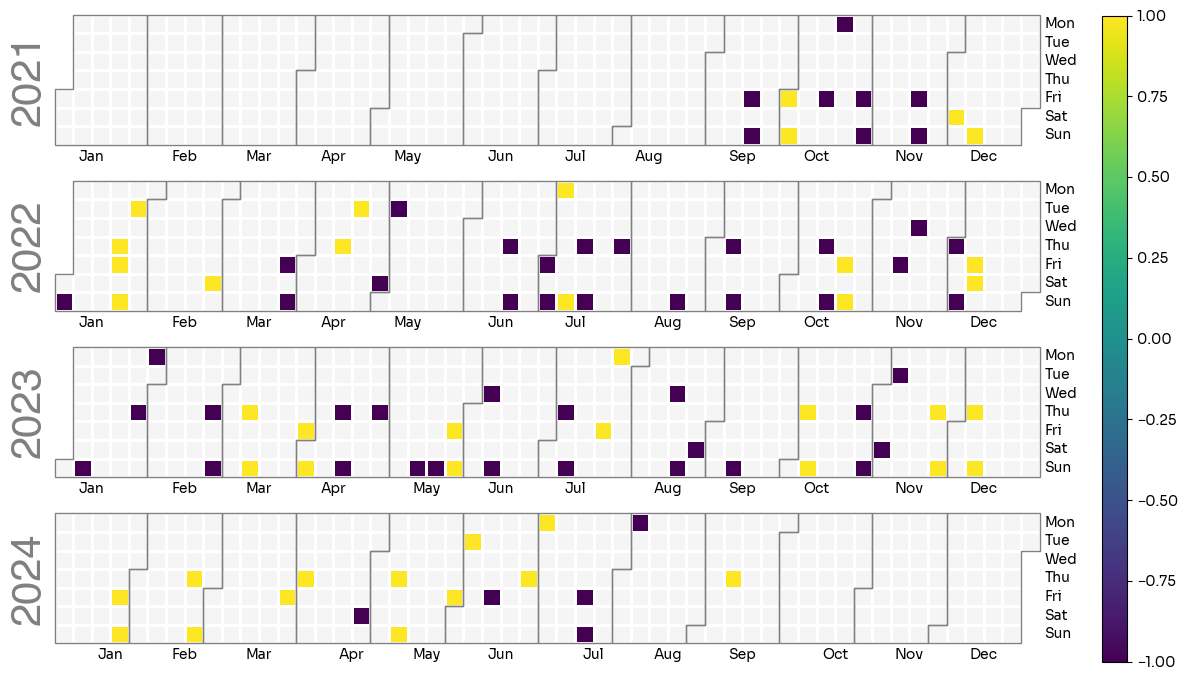

In [11]:
calplot.calplot(events, 
                dropzero = True,
               )

<Axes: >

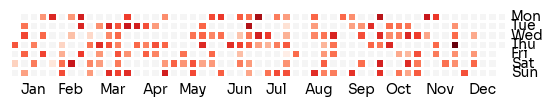

In [15]:
all_days = pd.date_range('1/15/2014', periods=700, freq='D')
days = np.random.choice(all_days, 500)
events = pd.Series(np.random.randn(len(days)), index=days)
calmap.yearplot(events, year=2015)

In [ ]:
### to add for later ###
# total distance travelled
# delays (like the apple watch rings)
    # day of week / time of day
# time spent travelling
# lumo vs lner?
# busiest days / months